In [43]:
require(tidyverse)
require(data.table)

## 1. Rationale

* due to the sparseness, the ps is binned to 20 (can change) 
* then chisq test wheter the ratio of openning is dependent on bins 

##  2. load data &  bin data

In [46]:
dat.pro_ps<- fread("../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts_ps.txt")

### ps.range
ps.range <- list()
ps.range$alpha <- range((dat.pro_ps %>%filter(cluster %in% c("alpha_1","alpha_2")))$ps)
ps.range$beta <- range((dat.pro_ps %>%filter(cluster %in% c("beta_1","beta_2")))$ps)2
ps.range

$alpha
[1] 0.000000 6.746176

$beta
[1]  0.0000 20.2079

In [156]:
dim(dat.pro_ps)

[1] 19412387        6

In [152]:
N.bin<- 11
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1],ps.range$alpha[2],length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1],ps.range$beta[2],length.out = N.bin)

dat.pro_ps <- rbind(
    dat.pro_ps%>% 
    filter(cluster %in% c("alpha_1","alpha_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$alpha,include.lowest = T)),
    dat.pro_ps%>% 
    filter(cluster %in% c("beta_1","beta_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$beta,include.lowest = T))
)%>%separate(cluster,into=c("celltype","subtype"))

ps.bin.dat.sum<- dat.pro_ps%>%
    select(-one_of("gene_tr.idx","ps"))%>%distinct()

setDT(ps.bin.dat.sum)
ps.bin.dat.sum<-ps.bin.dat.sum[, .(.N), by = .(ps_bin,celltype)]
cat(paste(N.bin,"# bins:\n"))
cat("quantiles of alpha cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="alpha"))$N))
cat("quantiles of beta cell number per bin:\n")
t(quantile((ps.bin.dat.sum%>%filter(celltype=="beta"))$N))

11 # bins:
quantiles of alpha cell number per bin:


0%,25%,50%,75%,100%
210,365.75,590,728.5,845


quantiles of beta cell number per bin:


0%,25%,50%,75%,100%
131,250.25,592.5,968.25,1904


In [9]:
ps.bin.dat.sum%>%group_by(celltype)%>%summarise(tot=sum(N))

celltype,tot
alpha,5594
beta,7170


In [10]:
#fwrite(dat.pro_ps,file = "../dat/1901/dat.pro_ps.csv")

## 3. run chisq test on dependence on bin

In [11]:
require(parallel)
ps.bin.dat.sum.2<-ps.bin.dat.sum%>%
    as.data.frame()%>%
    mutate(ps_bin =as.character(ps_bin))%>%
    column_to_rownames("ps_bin")

run_chisq_test<- function(g="SAMD11_7",dat){
    test.dat <- dat%>%
        mutate(ps_bin=droplevels(ps_bin))%>%
    filter(gene_tr.idx==g)%>%
    select(one_of("celltype","ps_bin"))

    test.dat.tab <- as.matrix(t(table(test.dat$ps_bin)))
    test.dat.tab<-rbind(test.dat.tab,ps.bin.dat.sum.2[colnames(test.dat.tab),'N']-test.dat.tab[1,])
    rownames(test.dat.tab)<- c("open","close")
    chisq <- chisq.test(test.dat.tab,simulate.p.value=F)
    chisq$p.value
}

system.time(res <- lapply(c("alpha","beta"),function(ct){
    dat.sub <- dat.pro_ps%>%filter(celltype ==ct)
    all_tr <- unique(dat.sub$gene_tr.idx)
    tmp <- mclapply(all_tr,function(g){
        run_chisq_test(g,dat=dat.sub)
    },mc.cores = 12)
    names(tmp) <- all_tr
    tmp
}))
names(res) <- c("alpha","beta")
for (i in names(res)){
    res[[i]] <- data.frame(pval=unlist(res[[i]]))%>%
        rownames_to_column("gene_tr.idx")
}



     user    system   elapsed 
27184.030  8246.239  5196.793 

##### add ajust value

In [56]:
# adjust for p value 
m<- c("fdr","bonferroni","BY");names(m)<-c("FDR","padj.Bonferroni","FDR.BY")
res <- lapply(res,function(df){
    res.genes_level.a.df <- as.data.frame(df)
    for(i in 1:3){
        res.genes_level.a.df[[names(m)[i]]] <- p.adjust(as.numeric(res.genes_level.a.df$pval),method = m[i])
    }
    res.genes_level.a.df
})
saveRDS(res,'../dat/1901/chisq_10bin_res.Rds')

In [52]:
range(-log10(as.numeric(res$alpha$pval)))
range(-log10(as.numeric(res$beta$pval)))

[1]  0.001206801 57.821802014

[1] 3.622164e-04 7.793578e+01

##### quick check

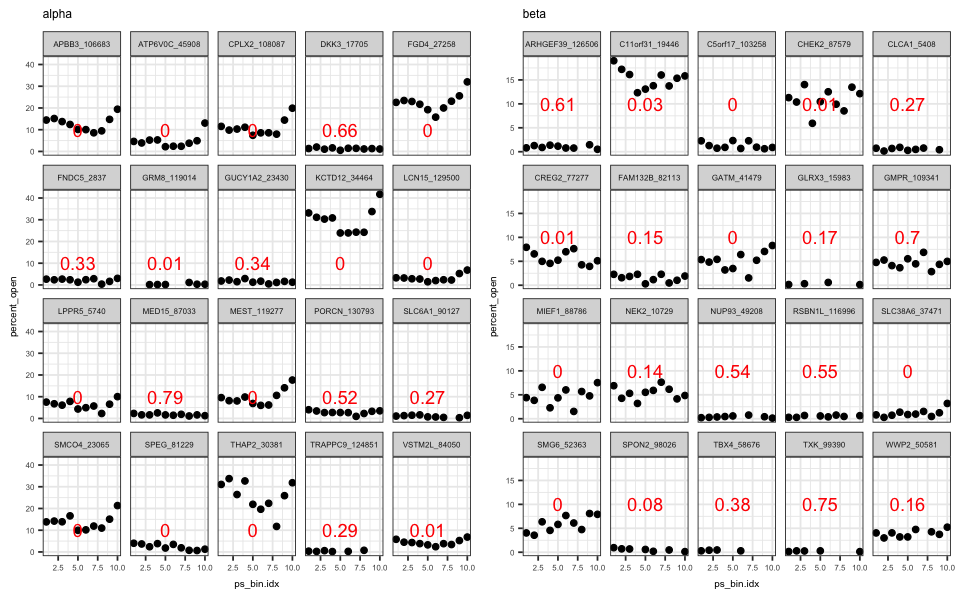

In [40]:
options(repr.plot.width=8, repr.plot.height=5)
p <- list()
for(ct in c("alpha","beta")){
    dat.pro_ps.filtered <- dat.pro_ps%>%filter(celltype ==ct)
    all_tr <- unique(dat.pro_ps.filtered$gene_tr.idx)
    selc <- sample(1:length(all_tr),20)
    dat.pro_ps.long <- dat.pro_ps.filtered%>%
        filter(gene_tr.idx %in% all_tr[selc])%>%
        group_by(gene_tr.idx,celltype,ps_bin)%>%
        summarise(n= n())%>%
        left_join(ps.bin.dat.sum)%>%arrange(gene_tr.idx,ps_bin)%>%
        droplevels()%>%     
        mutate(ps_bin.idx = as.numeric(ps_bin))%>% 
        mutate(percent_open=n/N*100)


    require(ggplot2)
    p[[ct]] <- ggplot(dat.pro_ps.long,aes(x = ps_bin.idx,y=percent_open))+
        geom_point()+facet_wrap(~gene_tr.idx)+theme_bw()+
        geom_text(data = res[[ct]][selc,]%>% mutate(pval=round(pval,2))%>%
        mutate(ps_bin.idx=5,percent_open=10)),aes(label=pval),color='red')+
    ggtitle(ct)+theme(text = element_text(size = 6))
}
require(ggpubr)
ggarrange(plotlist = p,ncol=2)


## 4. select dy promoters

In [97]:
res.df.wd <- rbind(res$alpha%>%mutate(celltype='alpha'),res$beta%>%mutate(celltype='beta'))%>%
    group_by(celltype)%>%
    arrange(pval)%>%
    mutate(ranks=rank(pval))
res.df.long<-res.df.wd%>%
    group_by(gene_tr.idx,celltype)%>%
    gather(key = "p.type",value = "p.value",2:5)
head(res.df.long)

gene_tr.idx,celltype,ranks,p.type,p.value
SLC2A13_27345,beta,1,pval,1.159374e-78
PDE4DIP_6755,beta,2,pval,2.503915e-77
ABCC8_17965,beta,3,pval,3.439504e-71
INPP4B_101706,beta,4,pval,2.154245e-62
FOSL1_21089,alpha,1,pval,1.507294e-58
ALOXE3_53509,alpha,2,pval,4.194117e-54


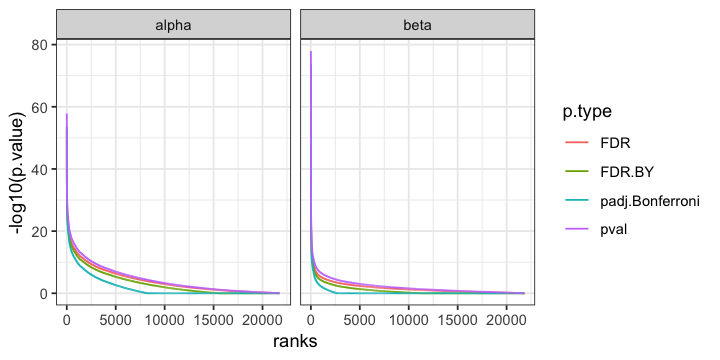

In [91]:
require(ggplot2)
options(repr.plot.width=6, repr.plot.height=3)

ggplot(res.df.long,aes(ranks,-log10(p.value)))+
    geom_line(aes(color=p.type))+
    facet_wrap(~celltype)+
    theme_bw()

In [117]:
dy.glist<- sapply(c("alpha","beta"),function(x)
    subset(res.df.wd,celltype==x & padj.Bonferroni<0.01)$gene_tr.idx
)
names(dy.glist)<- c("alpha_tr","beta_tr")
dy.glist$alpha <- unique(sapply(dy.glist$alpha,function(x) unlist(strsplit(x,split="_"))[1]))
dy.glist$beta <- unique(sapply(dy.glist$beta,function(x) unlist(strsplit(x,split="_"))[1]))
t(lapply(dy.glist,length))

alpha_tr,beta_tr,alpha,beta
5640,1155,5293,1103


### compare with binary list 

In [122]:
binary.glist <- readRDS('../dat/1901/binary.glist.Rds')
t(lapply(binary.glist,length))

alpha1_tr,alpha1,alpha2,alpha2_tr,beta1_tr,beta1,beta2,beta2_tr
185,179,1967,2042,182,178,682,696


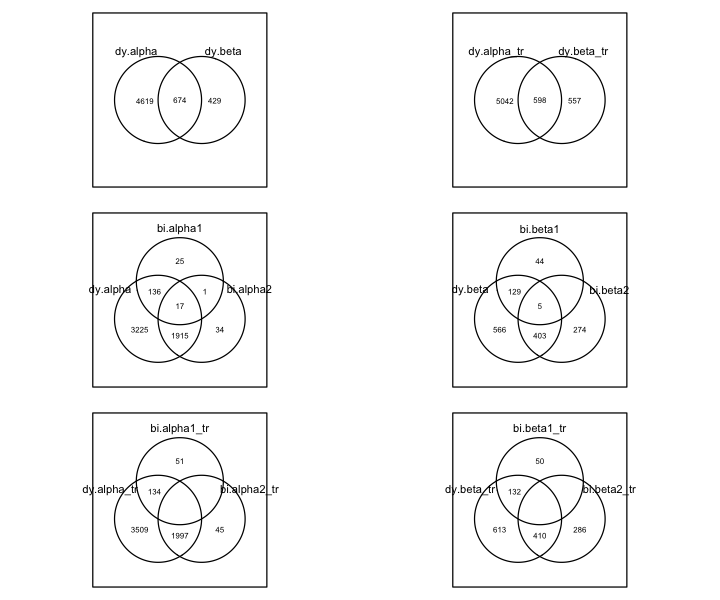

In [136]:
options(repr.plot.width=6, repr.plot.height=5)
require(venn)
par(mfrow=c(3,2))
venn(list(dy.alpha=dy.glist$alpha,dy.beta=dy.glist$beta))
venn(list(dy.alpha_tr=dy.glist$alpha_tr,dy.beta_tr=dy.glist$beta_tr))
venn(list(dy.alpha=dy.glist$alpha,
         bi.alpha1=binary.glist$alpha1,bi.alpha2=binary.glist$alpha2))
venn(list(dy.beta=dy.glist$beta,
         bi.beta1=binary.glist$beta1,bi.beta2=binary.glist$beta2))
venn(list(dy.alpha_tr=dy.glist$alpha_tr,
         bi.alpha1_tr=binary.glist$alpha1_tr,bi.alpha2_tr=binary.glist$alpha2_tr))
venn(list(dy.beta_tr=dy.glist$beta_tr,
         bi.beta1_tr=binary.glist$beta1_tr,bi.beta2_tr=binary.glist$beta2_tr))

* most of all alpha binary genes are included in alpha dynamical genes
* 1/3 beta binary genes are not included in dynamical genes 

### filtering on max fraction accross 20 ps bins

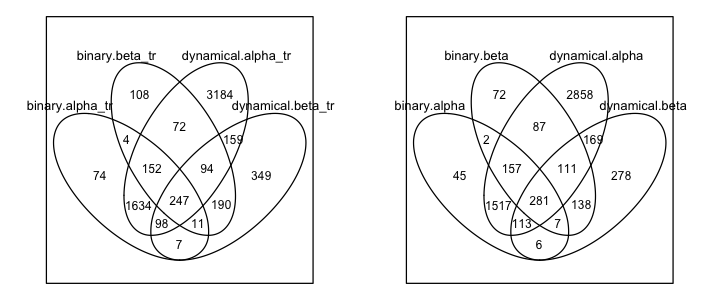

In [150]:
options(repr.plot.width=6, repr.plot.height=2.5)
par(mfrow=c(1,2))
all.list.tr <- list(binary.alpha_tr= c(binary.glist$alpha1_tr,binary.glist$alpha2_tr),
                 binary.beta_tr=c(binary.glist$beta1_tr,binary.glist$beta2_tr),
                 dynamical.alpha_tr=dy.glist$alpha_tr,
                 dynamical.beta_tr=dy.glist$beta_tr)
all.list.gene <- list(binary.alpha= c(binary.glist$alpha1,binary.glist$alpha2),
                 binary.beta=c(binary.glist$beta1,binary.glist$beta2),
                 dynamical.alpha=dy.glist$alpha,
                 dynamical.beta=dy.glist$beta)
venn(all.list.tr,ellipse = T,cexsn =.65 )
venn(all.list.gene,ellipse = T,cexsn = .65)

In [157]:
saveRDS(list(all.list.tr,all.list.gene),file = "../dat/1901/all.list.Rds")

## 5. clustering 

In [ ]:
# range((res.df%>% filter(celltype=="alpha"))$ranks)
range((res.df%>% filter(celltype=="beta"))$ranks)